In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape
from keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Section 1 : Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.

In [2]:
# Loading The Data
(x_train_mnist, _), (x_test_mnist, _) = mnist.load_data()

# PreProcess The Data
def pre_process(X):
    X = X/255.0
    return X

x_train_mnist = pre_process(x_train_mnist)
x_test_mnist = pre_process(x_test_mnist)

In [3]:
def add_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(50)/(255), dtype=tf.float32)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img

In [4]:
x_noise_mnist = add_gaussian_noise(x_train_mnist)
x_noise_test_mnist = add_gaussian_noise(x_test_mnist)

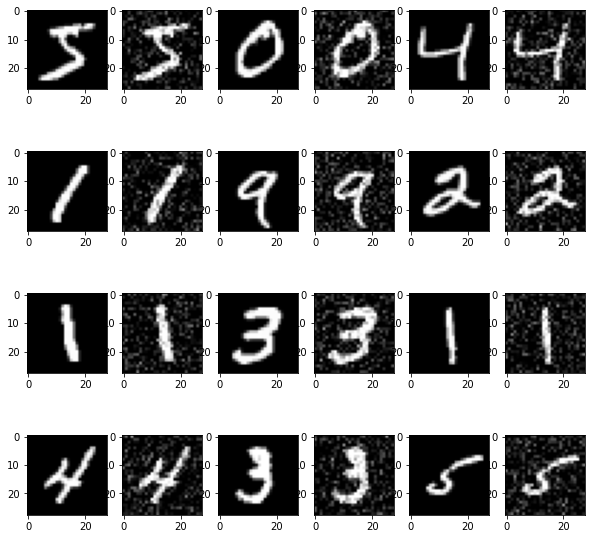

In [16]:
plt.figure(figsize= (10, 10))
for i in range(0, 12):
    plt.gray()
    plt.subplot(4, 6, 2*i+1)
    plt.imshow(x_train_mnist[i].reshape(28,28))
    plt.subplot(4, 6, 2*i+2)
    plt.imshow(x_noise_mnist[i].reshape(28,28))
    

In [7]:
print("Shape of train: "+str(x_train_mnist.shape))
print("Shape of noisy train: "+str(x_noise_mnist.shape))
print("Shape of test: "+str(x_test_mnist.shape))
print("Shape of noisy test: "+str(x_noise_test_mnist.shape))

Shape of train: (60000, 28, 28)
Shape of noisy train: (60000, 28, 28)
Shape of test: (10000, 28, 28)
Shape of noisy test: (10000, 28, 28)


# Section 2 : Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.

In [8]:
def AutoEncoder():
    
    # Input Layer
    input_layer = Input(shape=(28,28,), name="input_layer")
    
    #flatten
    flatten_layer=tf.keras.layers.Flatten()(input_layer)

    # encoder
    h_1 = Dense(1024, activation='relu', name="hidden_layer_1")(flatten_layer)
    h_2 = Dense(512, activation='relu', name="hidden_layer_2")(h_1)
    h_3 = Dense(256, activation='relu', name="hidden_layer_3")(h_2)
    h_4 = Dense(128, activation='relu', name="hidden_layer_4")(h_3)
    h_5 = Dense(64, activation='relu', name="hidden_layer_5")(h_4)
    h_6 = Dense(32, activation='relu', name="hidden_layer_6")(h_5)
    
    # code layer
    code_layer = Dense(16, activation='relu', name="code_layer")(h_6)
    
    # decoder
    h_7 = Dense(32, activation='relu', name="hidden_layer_7")(code_layer)
    h_8 = Dense(64, activation='relu', name="hidden_layer_8")(h_7)
    h_9 = Dense(128, activation='relu', name="hidden_layer_9")(h_8)
    h_10 = Dense(256, activation='relu', name="hidden_layer_10")(h_9)
    h_11 = Dense(512, activation='relu', name="hidden_layer_11")(h_10)
    h_12 = Dense(1024, activation='relu', name="hidden_layer_12")(h_11)
    
    # Output Layer
    output_layer = Dense(784, activation='sigmoid', name="output_layer")(h_12)
    output_layer = Reshape((28,28))(output_layer)
    model = Model(input_layer, output_layer)
    
    return model

In [9]:
Auto_Encoder = AutoEncoder()
Auto_Encoder.compile(optimizer='adam', loss='binary_crossentropy')
Auto_Encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1024)              803840    
                                                                 
 hidden_layer_2 (Dense)      (None, 512)               524800    
                                                                 
 hidden_layer_3 (Dense)      (None, 256)               131328    
                                                                 
 hidden_layer_4 (Dense)      (None, 128)               32896     
                                                                 
 hidden_layer_5 (Dense)      (None, 64)                8256  

In [10]:
history = Auto_Encoder.fit(x_noise_mnist, x_train_mnist, epochs=40, validation_data=(x_noise_test_mnist,x_test_mnist))

Epoch 1/40
1875/1875 [==============================] - 15s 7ms/step - loss: 0.1959 - val_loss: 0.1573
Epoch 2/40
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1479 - val_loss: 0.1407
Epoch 3/40
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1371 - val_loss: 0.1337
Epoch 4/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1317 - val_loss: 0.1302
Epoch 5/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1283 - val_loss: 0.1281
Epoch 6/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1258 - val_loss: 0.1266
Epoch 7/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1243 - val_loss: 0.1259
Epoch 8/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1227 - val_loss: 0.1241
Epoch 9/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1213 - val_loss: 0.1238
Epoch 10/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epoch')]

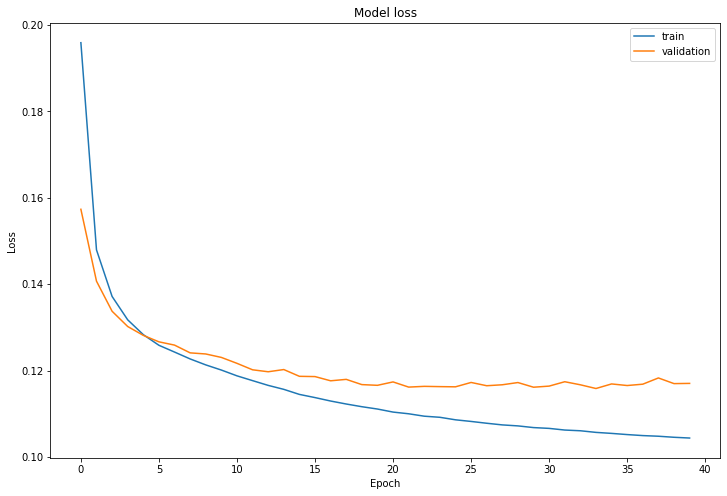

In [11]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')

# Section 3 : Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.

313/313 [==============================] - 2s 7ms/step


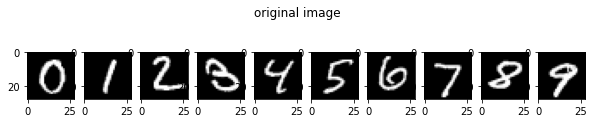

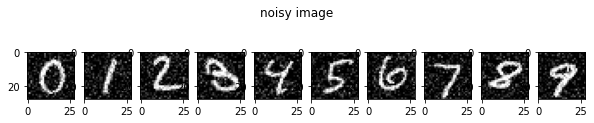

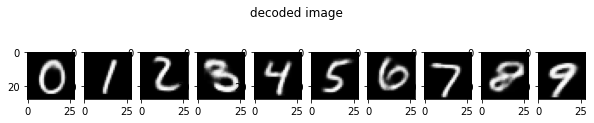

In [13]:
decoded_data_mnist = Auto_Encoder.predict(x_noise_test_mnist)
def display_data(data , title):
    plt.figure(figsize=(10, 2))
    i=0
    for j in [13,5,1,18,6,23,11,0,61,9]:#the list is indexes of digits that has been displayed below
        ax = plt.subplot(1,10,i+1)
        i=i+1
        plt.imshow(data[j])
        plt.gray()        
    plt.suptitle(title)
display_data(x_test_mnist , title="original image")
display_data(x_noise_test_mnist, title="noisy image")
display_data(decoded_data_mnist , title="decoded image")

# Section 4 : Compute latent feature vectors of images. (The output of the encoder network)

In [15]:
encoder_mnist = Model(inputs=Auto_Encoder.input, outputs=Auto_Encoder.get_layer("code_layer").output)
encoded_data_mnist = encoder_mnist.predict(x_noise_test_mnist)

313/313 [==============================] - 2s 3ms/step


# Section 5 : Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.

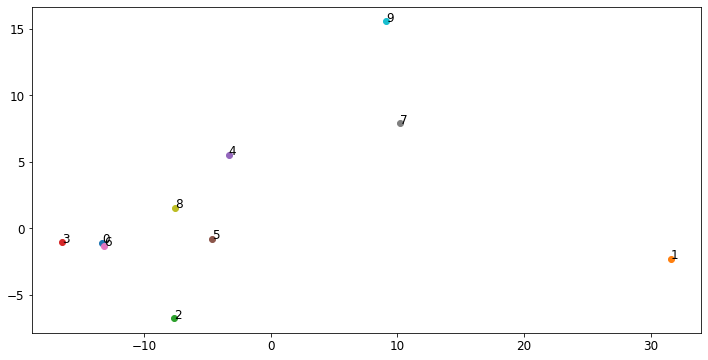

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(encoded_data_mnist)
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.rcParams['font.size'] = '12'
j=0
for i in [13,5,1,18,6,23,11,0,61,9]:
  ax.scatter(X_pca[i, 0], X_pca[i, 1])
  ax.annotate(j, (X_pca[i, 0], X_pca[i, 1]))
  j = j + 1

#Section 6 : Repeat the previous step with TSNE.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


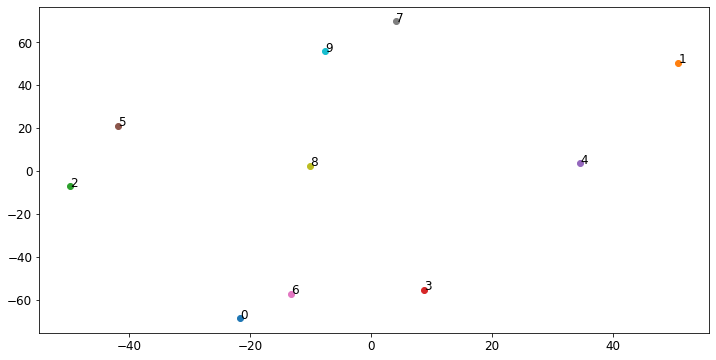

In [23]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(encoded_data_mnist)
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.rcParams['font.size'] = '12'
j=0
for i in [13,5,1,18,6,23,11,0,61,9]:
  ax.scatter(X_tsne[i, 0], X_tsne[i, 1])
  ax.annotate(j, (X_tsne[i, 0], X_tsne[i, 1]))
  j = j + 1

#Section 7 : What do you conclude from steps 4 and 5 about the learned latent representation of the data?

In [2]:
print("1. Dimensionality reduction can decrease training time\n2. Using latent feature representations can enhance model performance")

1. Dimensionality reduction can decrease training time
2. Using latent feature representations can enhance model performance
